In [10]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

from tqdm import tqdm_notebook

In [74]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings

# def mad(dat): #median absolute deviation
#     return np.median(np.absolute(dat - np.median(dat)))

class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by finding its apparent magnitude from its spectroscopic parameters.
    The actual fitting of age and extinction is done by using a fitter with the functions in this 
    class.
    '''
    def __init__(self,mh,am,distance,bands,parsec):
        
        '''
        feh: [float] metallicity [M/H] of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        bands: [dictionary] the PARSEC label and effective wavelengths in \AA
        i.e. bands = {'Jmag':12375.60,'Hmag':16476.02,'Ksmag':21620.75}. The last band in 
        bands is used as the fiducial band when calculating extinction values
        parsec: [astropy Table] PARSEC isochrone table
        '''
        
        ### stellar parameters
        self.salfeh = mh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.distmod = 5.0*np.log10(distance)-5.0
        
        ### PARSEC isochrones
        
        # extract PARSEC labels and effective wavelengths from bands dictionary
        self.labels = np.array([])
        for key in bands.keys():
            self.labels = np.append(self.labels,key)
            
        self.leff = np.array([])
        for value in bands.values():
            self.leff = np.append(self.leff,value)
        
        self.leff = self.leff/10**4 # convert to mircons
        
        # get list of unique ages in isochrone table
        self.uniq_ages = np.unique(parsec['logAge'])
        self.iso = parsec[np.where(parsec['MH']==self.closest(parsec['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                   
    #########################
    ### Utility Functions ###
    #########################
    
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ############################################
    #### Cardelli et al. 1989 Extinction Law ###
    ############################################
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave,rv):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/rv
        return alav
     
    #################################
    ### Age Calculation Functions ###
    #################################
    
    def InitialAge(self,teff,mag,al):
        '''
        Calculate an initial guess for the age of a star
        
        Inputs:
        ------
            teff: temperature of a star
            kmag: K magnitude of a star
            al: extinction in a fiducial band taken to be the last band in self.labels 
            from __init__
        
        Output:
        ------
            age_guess: initial guess for age
        
        '''
        
        iso_ = self.iso[np.where(self.iso['MH']==self.closest(self.iso['MH'],self.salfeh))]
        
        euclid = (np.subtract(iso_['Ksmag'],mag-al-self.distmod)**2+
                  np.subtract(10**iso_['logTe'],teff)**2)
        
        age_guess = np.median(10**iso_['logAge'][euclid.argmin()]/10**9)
        
        return age_guess    
        
    def Teff2AppMags(self,teff,age,al):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            al: extinction in a fiducial band taken to be the last band in self.labels 
            from __init__
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #### Some calcualtions to set things up
        
        # Get log of arguments
        lgteff = np.log10(teff) 
        lgage = np.log10(age*10**9)
        
        # Calculate the extinction values use Cardelli et al. 1989
        extinct = np.ones(len(self.labels))*al
        for i in range(len(self.labels)):
            extinct[i] = self.cardelli_alav(self.leff[i],3.1)/self.cardelli_alav(self.leff[-1],3.1)
        
        ### Calculate apparent magnitude is input age is one of the grid points
        if lgage in self.uniq_ages:
            
            # pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                warnings.warn('Warning: Temperature outside isochrone range for given age and [Fe/H]')
                return 999999.0*np.array(len(self.labels))
            
            # sort so temp is always increasing and unique
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            # use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(len(self.labels))
            for i in range(self.labels):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extinct[i]
            
            return calc_mags
            
        ### Calculate apparent magnitude is input age is not one of the grid points
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            
            # Pick out single isochrones
        
            # younger age
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older age
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            # Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                warnings.warn('Warning: Temperature outside isochrone range for given age_lo and [Fe/H]')
                return 999999.0*np.array(len(self.labels))
            
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                warnings.warn('Warning: Temperature outside isochrone range for given age_hi and [Fe/H]')
                return 999999.0*np.array(len(self.labels))
            
            # sort so temp is always increasing and unique
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(self.labels):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extinct[i]
            
            return calc_mags

In [78]:
test = {'G_BPmag':5128.97,'Gmag':6424.93,'G_RPmag':7799.18,'Jmag':12375.60,'Hmag':16476.02,'Ksmag':21620.75}

self.labels = np.array([])

for key in bands.keys():
    self.labels = np.append(self.labels,key)

array(['G_BPmag', 'Gmag', 'G_RPmag', 'Jmag', 'Hmag', 'Ksmag'],
      dtype='<U32')

In [18]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

In [19]:
print('aj_ak',cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1))
print('ah_ak',cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1))

aj_ak 2.490197238236482
ah_ak 1.5773727079807909


# Parsec

In [7]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]
massive = massive[np.argsort(massive['logAge'])]
massive = Table(massive)['MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [4]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
# idx = 1024
# gcs1024 =np.diag([gcs['TEFF_ERR'][idx],gcs['FE_H_ERR'][idx],gcs['ALPHA_M_ERR'][idx],gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
# corr = np.round(np.corrcoef((gcs['TEFF'],gcs['FE_H'],gcs['ALPHA_M'],gcs['J'],gcs['H'],gcs['K'])),3)

# np.round(gcs1024)
# np.round(np.dot(gcs1024,np.dot(corr,gcs1024))/np.max(np.dot(gcs1024,np.dot(corr,gcs1024))),5)

In [5]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# Test Code

In [8]:
from scipy.optimize import curve_fit
uniq_ages = np.unique(massive['logAge'])

# Ages in uniq_ages

In [34]:
mags = np.zeros((56,5))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(uniq_ages))[::10]):
    mags[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**uniq_ages[i]/10**9,0)


In [35]:
mags[:,0]

array([9.66734380e+00, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 1.30322577e+01, 1.31117109e+01,
       1.31772756e+01, 1.32384094e+01, 1.32894473e+01, 1.33425618e+01,
       1.33900066e+01, 1.34330829e+01, 1.34699582e+01, 1.35017955e+01,
       1.35305047e+01, 1.35602112e+01, 1.35847233e+01, 1.36096473e+01,
       1.36309321e+01, 1.36535155e+01, 1.36737479e+01, 1.36917691e+01,
       1.37118788e+01, 1.37302429e+01, 1.37482817e+01, 1.37640274e+01,
       1.37817878e+01, 1.37979257e+01, 1.38124118e+01, 1.38270749e+01,
       1.38408017e+01, 1.38536889e+01, 1.38665797e+01, 1.38791053e+01,
       1.38900478e+01, 1.39023557e+01, 1.39137733e+01, 1.39222618e+01,
       1.39343149e+01, 1.39423695e+01, 1.39531995e+01, 1.39622820e+01,
       1.39730581e+01, 1.39821273e+01, 1.39901601e+01, 1.39992099e+01,
       1.40069982e+01, 1.40154707e+01, 1.40225645e+01, 1.40331881e+01,
       1.40422095e+01, 1.40481325e+01, 1.40564520e+01, 1.40643398e+01])

Text(0, 0.5, 'K')

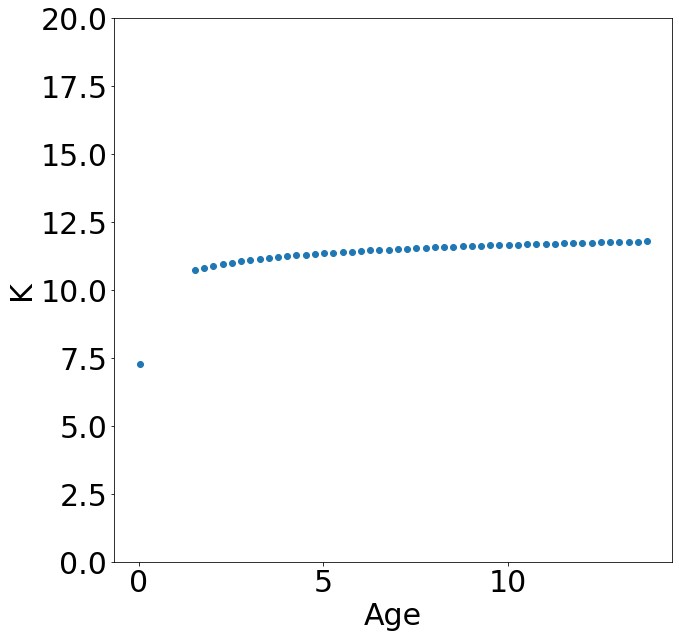

In [36]:
plt.figure(figsize=[10,10])
plt.scatter(10**uniq_ages[::10]/10**9,mags[:,2])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

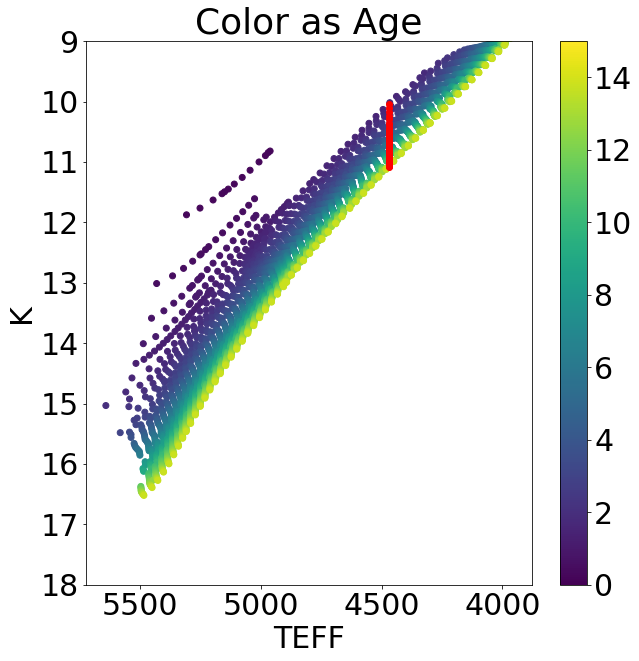

In [37]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags[:,4],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

In [39]:
mags1 = np.zeros((56,5))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(uniq_ages))[::10]):
    mags1[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**uniq_ages[i]/10**9,1.)

Text(0, 0.5, 'K')

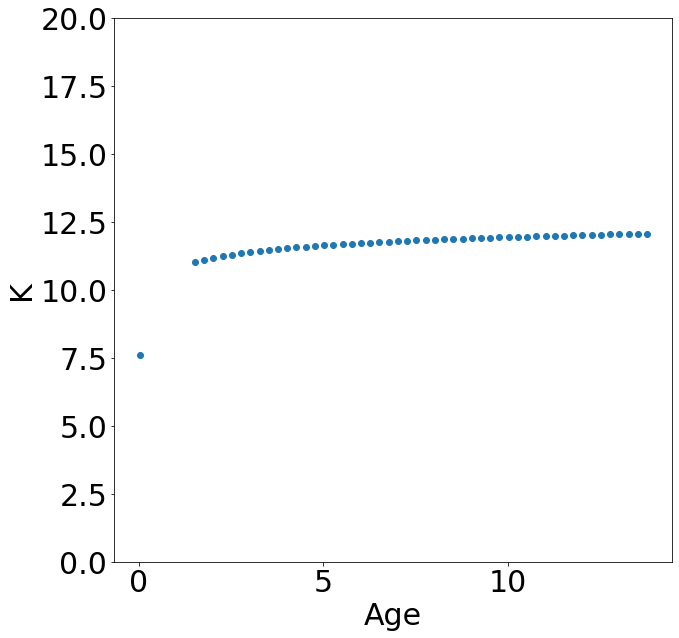

In [41]:
plt.figure(figsize=[10,10])
plt.scatter(10**uniq_ages[::10]/10**9,mags1[:,4])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

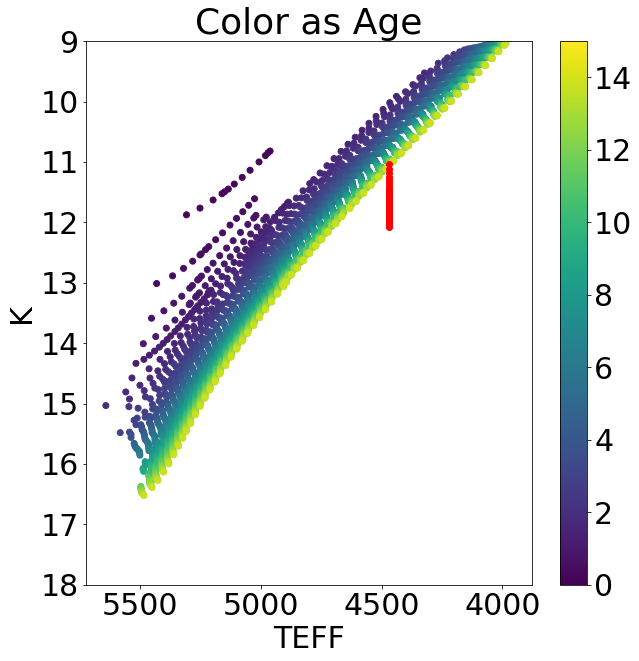

In [42]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags1[:,4],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

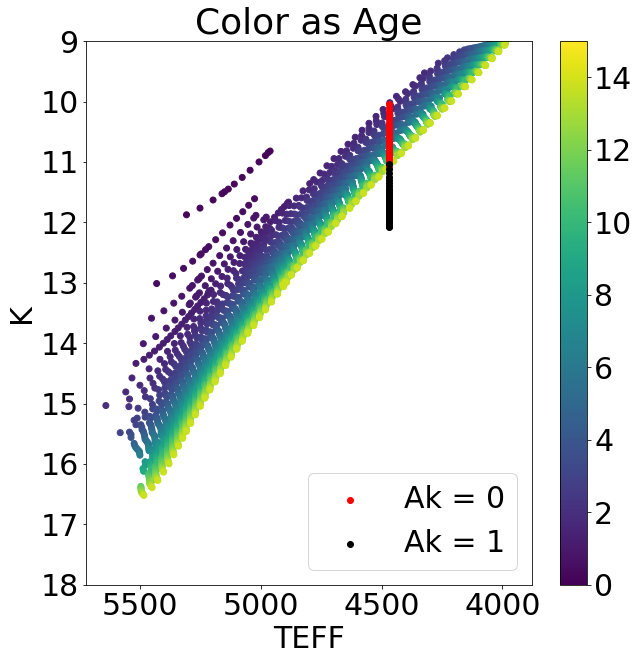

In [43]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags[:,4],c='r',label='Ak = 0')
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags1[:,4],c='k',label='Ak = 1')
plt.legend()
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

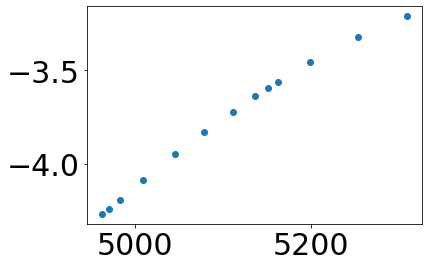

In [44]:
test = np.where(CalcAge.iso['logAge']==8.43933)
plt.scatter(10**CalcAge.iso['logTe'][test],CalcAge.iso['Ksmag'][test])

# Ages not in uniq_ages

In [45]:
print(np.median(np.diff(10**uniq_ages/10**9)))
print(np.max(10**uniq_ages/10**9))
print(np.min(10**uniq_ages/10**9))

0.02499999625598079
14.000063322395283
0.02499999950079735


In [46]:
not_uniq_ages = np.abs(np.random.normal(10**uniq_ages/10**9,1.0,560))
for i in range(len(not_uniq_ages)):
    if not_uniq_ages[i] > 14.:
        not_uniq_ages[i] -= max(not_uniq_ages)-14.0
    if not_uniq_ages[i] < 0.025:
        not_uniq_ages[i] += 0.025 - min(not_uniq_ages)
not_uniq_ages = np.log10((not_uniq_ages[np.argsort(not_uniq_ages)])*10**9)

In [57]:
not_mags = np.zeros((56,5))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(not_uniq_ages))[::10]):
    not_mags[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**not_uniq_ages[i]/10**9,0)

Text(0, 0.5, 'K')

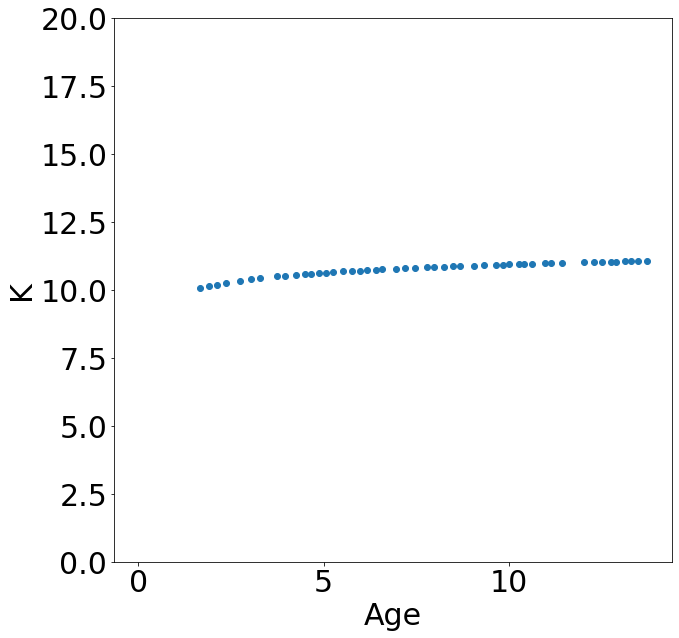

In [60]:
plt.figure(figsize=[10,10])
plt.scatter(10**not_uniq_ages[::10]/10**9,not_mags[:,4])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

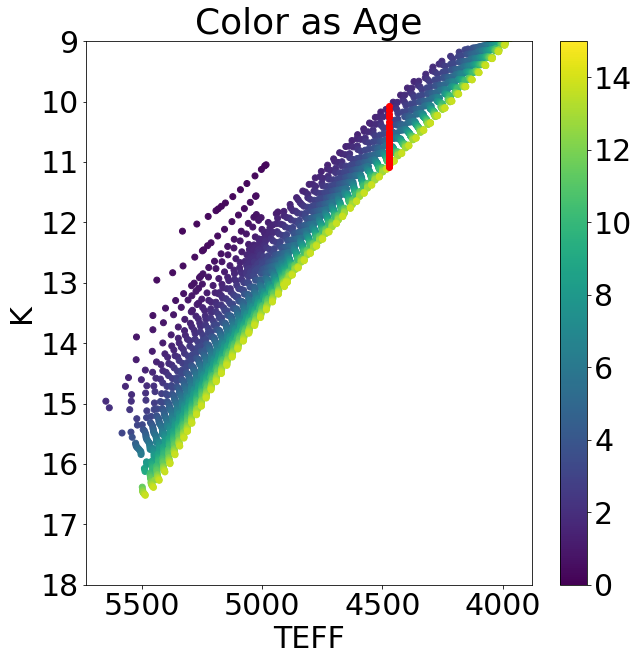

In [61]:
plt.figure(figsize=[10,10])
for i in range(len(not_uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==closest(CalcAge.iso['logAge'],not_uniq_ages[::10][i]))
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags[:,4],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

In [63]:
not_mags1 = np.zeros((56,5))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(not_uniq_ages))[::10]):
    not_mags1[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**not_uniq_ages[i]/10**9,1.)

(0.0, 20.0)

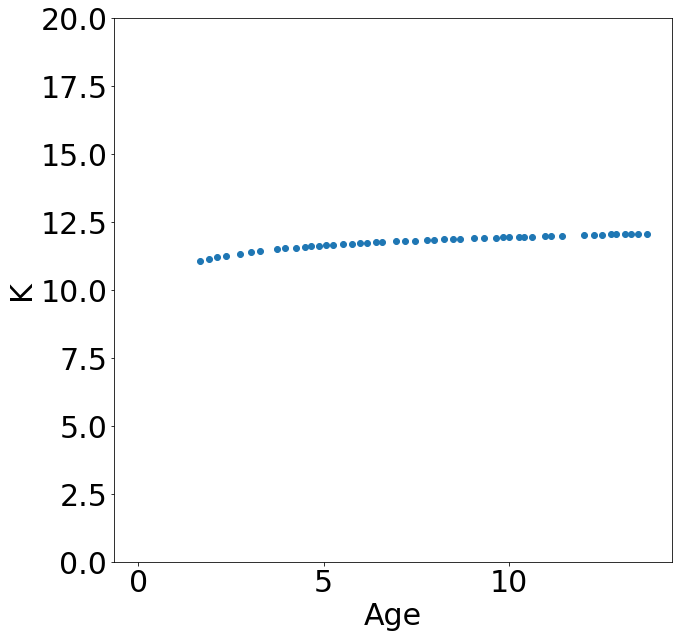

In [64]:
plt.figure(figsize=[10,10])
plt.scatter(10**not_uniq_ages[::10]/10**9,not_mags1[:,4])
plt.xlabel(r'Age')
plt.ylabel(r'K')
plt.ylim(0,20)

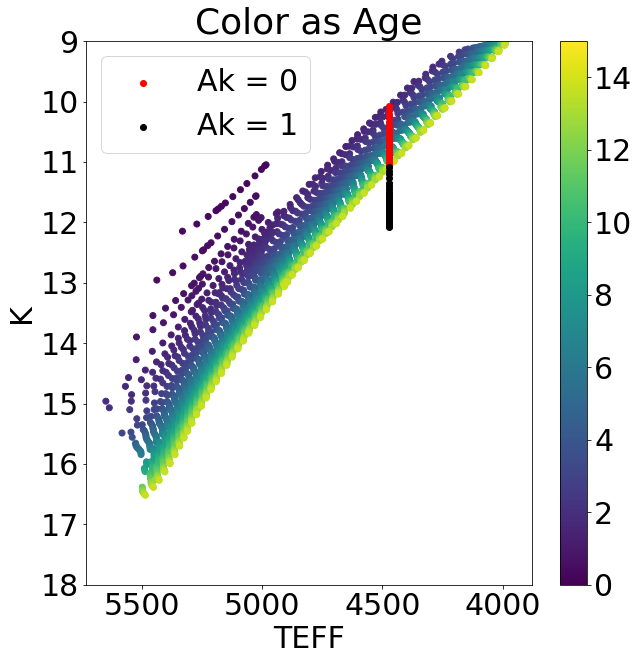

In [66]:
plt.figure(figsize=[10,10])
for i in range(len(not_uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==closest(CalcAge.iso['logAge'],not_uniq_ages[::10][i]))
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags[:,4],c='r',label='Ak = 0')
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags1[:,4],c='k',label='Ak = 1')
plt.legend()
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

In [70]:
gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

# curve_fit Test

In [73]:
from scipy.optimize import curve_fit

#[CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx]),
#                           gcs['AK_TARG'][idx]]

p0 = [12.0,0.5]

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx])

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([gcs['GAIA_PHOT_BP_MEAN_MAG'][idx],gcs['GAIA_PHOT_RP_MEAN_MAG'][idx],
                                gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]],dtype=float).T.ravel(),
                      p0=p0,bounds=((0.,0.),(14.,2.)),method='trf')

# print('Initial Age',CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx]))
# print('AK_TARG',gcs['AK_TARG'][idx])
print('Initial',p0)
print('Age; Ak',popt)
print(pcov)

Initial [12.0, 0.5]
Age; Ak [5.48375787 0.02332413]
[[ 6.11257961e-03 -1.30079662e-04]
 [-1.30079662e-04  5.38628286e-06]]


In [325]:
ages0 = np.arange(0,14)
aks0 = [0,0.5,1.0]

initial_age = np.array([])
initial_aks = np.array([])

# chi = 999999.0*np.ones((len(ages0),len(aks0)))
chi = []

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
age = []
ak = []
cmags = []

for i in tqdm_notebook(range(len(ages0))):
    for j in range(len(aks0)):
        
        popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel(),
                      p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf',
                          sigma=[gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
    
        age.append(popt[0])
        ak.append(popt[1])
        
        initial_age = np.append(initial_age,ages0[i])
        initial_aks = np.append(initial_aks,aks0[j])
        
        calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        cmags.append(calc_mags)
        
        mag_errs = np.array([gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
        mags = np.array([gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]])
    
        chi1 = sum((calc_mags-mags)**2/mag_errs**2)
        
        chi.append(chi1)
    
bestind = np.asarray(chi).argmin()
bestchi = np.min(chi)  
bestage = age[bestind] 
bestak = ak[bestind]
# bestmag = cmags[bestind]

print('chi',bestchi)
print('Age',bestage)
print('Ak',bestak)


chi 0.5172713604833895
Age 5.099939242972178
Ak 0.0456703707503562


In [338]:
theo_mags = []
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
for i in range(0,14):
    theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][idx],i,0))
    
print(theo_mags)

[(999999.0, 999999.0, 999999.0), (999999.0, 999999.0, 999999.0), (11.527674193940264, 10.9521163814667, 10.865759469936506), (11.75442920575605, 11.179413648123102, 11.092663792668361), (11.903731574691907, 11.329393245734352, 11.243126708303873), (12.009836774248456, 11.435416947751879, 11.349322772067183), (12.09333349794727, 11.519143032169023, 11.433040732381563), (12.168651894576868, 11.594002871831421, 11.50794145834627), (12.232471314628459, 11.657607612646672, 11.571480552379143), (12.285723220610397, 11.71037899334257, 11.62431936882875), (12.334185618526135, 11.758315206926984, 11.672329386291963), (12.376481429761867, 11.801393748487062, 11.715239135867858), (12.41525967120856, 11.840262895394979, 11.75399534814493), (12.45135397738036, 11.8754769216245, 11.789659769060613)]


In [339]:
# plt.figure(figsize=[10,10])
# plt.plot(np.asarray(theo_mags)[:,0],range(0,14),label='J')
# plt.axhline(bestage,ls='--')
# plt.axvline(gcs['J'][idx],ls='--')
# plt.xlim(10,13)
# plt.ylim(3.,8.)


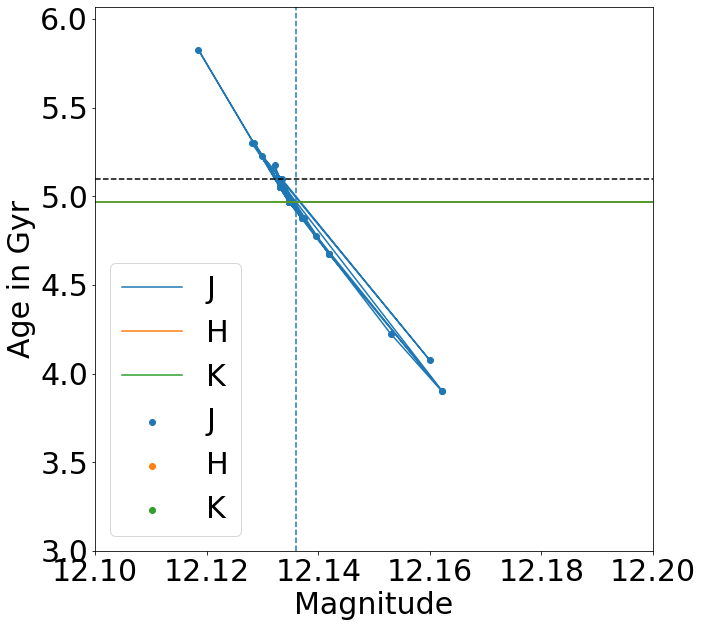

In [303]:
plt.figure(figsize=[10,10])

plt.scatter(np.asarray(cmags)[:,0],age,label='J')
plt.scatter(np.asarray(cmags)[:,1],age,label='H')
plt.scatter(np.asarray(cmags)[:,2],age,label='K')
plt.plot(np.asarray(cmags)[:,0],age,label='J')
plt.plot(np.asarray(cmags)[:,1],age,label='H')
plt.plot(np.asarray(cmags)[:,2],age,label='K')
plt.legend()

plt.axhline(bestage,ls='--',c='k')
plt.axvline(gcs[idx]['J'],ls='--',c='tab:blue')
plt.axvline(gcs[idx]['H'],ls='--',c='tab:orange')
plt.axvline(gcs[idx]['K'],ls='--',c='tab:green')

# plt.xlim(11,12.5)
plt.xlim(12.2,12.10)
plt.ylim(bottom=3.)
plt.gca().invert_xaxis()
plt.xlabel('Magnitude')
plt.ylabel('Age in Gyr')
plt.show()

In [347]:
aj_ak = cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1)
ah_ak = cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1)

exts = np.array([bestak*aj_ak,bestak*ah_ak,bestak])

In [349]:
gcs['CLUSTER'][idx]

'M3'

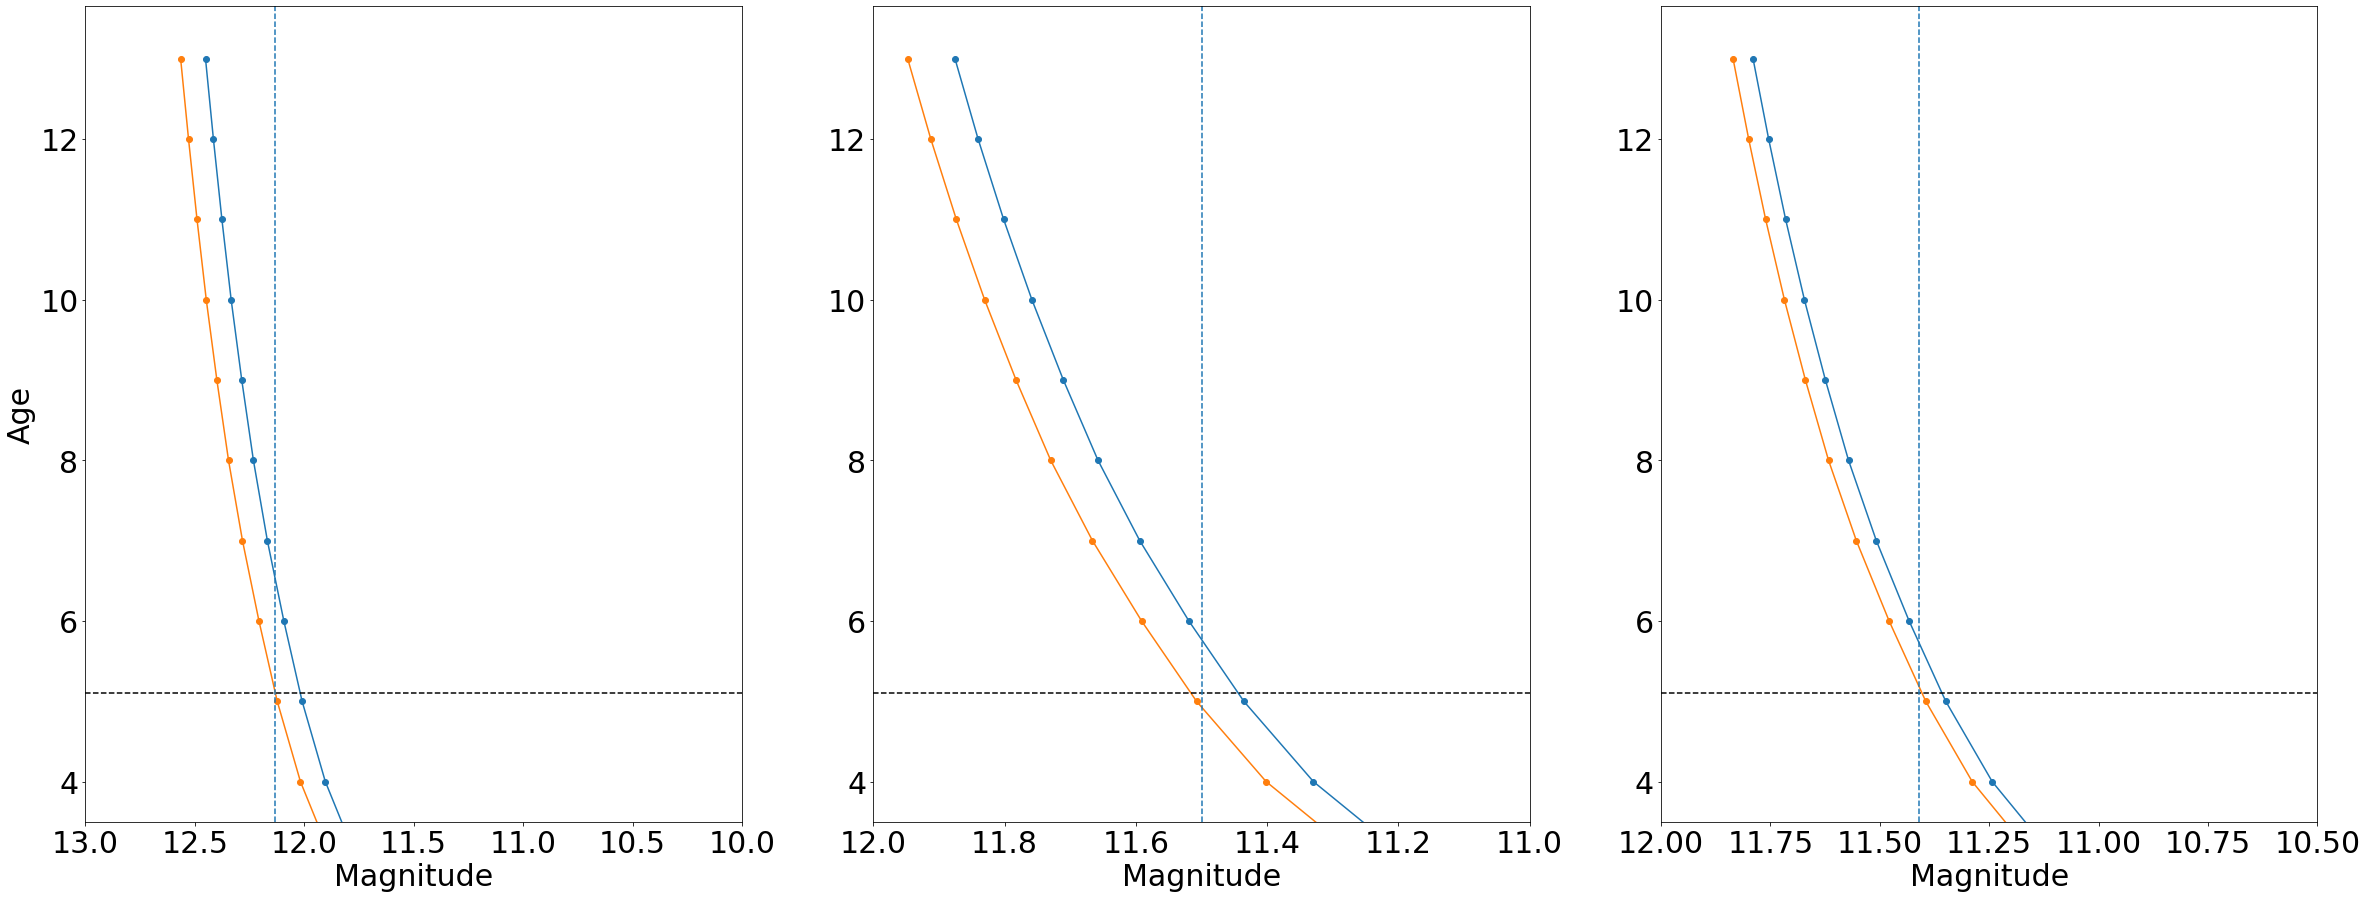

In [348]:
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].set_ylim(bottom=3.5)
    ax[i].axhline(bestage,c='k',ls='--')
    ax[i].set_xlabel('Magnitude')

ax[0].axvline(gcs[idx]['J'],ls='--',c='tab:blue')
ax[1].axvline(gcs[idx]['H'],ls='--',c='tab:blue')
ax[2].axvline(gcs[idx]['K'],ls='--',c='tab:blue')

ax[0].set_xlim(13,10)
ax[1].set_xlim(12,11.)
ax[2].set_xlim(12,10.5)

ax[0].set_ylabel('Age')
plt.show()

In [297]:
cmags

[array([999999., 999999., 999999.]),
 array([999999., 999999., 999999.]),
 array([999999., 999999., 999999.]),
 array([12.13473418, 11.51475525, 11.39981569]),
 array([12.13473418, 11.51475525, 11.3998157 ]),
 array([12.13473418, 11.51475525, 11.3998157 ]),
 array([12.16216028, 11.48931365, 11.34139105]),
 array([12.15295764, 11.49780258, 11.36060579]),
 array([12.13954898, 11.51028164, 11.3894679 ]),
 array([12.13305753, 11.51571823, 11.40386113]),
 array([12.13294374, 11.51605296, 11.40461155]),
 array([12.13738863, 11.51290937, 11.39503816]),
 array([12.13308805, 11.51573756, 11.40387338]),
 array([12.13473418, 11.51475525, 11.3998157 ]),
 array([12.13308718, 11.515737  , 11.40387303]),
 array([12.11853346, 11.53004805, 11.43485344]),
 array([12.13473418, 11.51475525, 11.3998157 ]),
 array([12.13473418, 11.51475525, 11.3998157 ]),
 array([12.1299295 , 11.51913758, 11.41021301]),
 array([12.15998782, 11.49634375, 11.35321227]),
 array([12.13338023, 11.51632945, 11.40478683]),
 array(

In [233]:
chi

array([[6.40923574e+15, 6.40923574e+15, 6.40923574e+15],
       [6.28618969e-01, 6.28618969e-01, 6.28618969e-01],
       [1.30118686e+01, 6.55729988e+00, 1.26084056e+00],
       [5.22969569e-01, 5.17347750e-01, 8.48502805e-01],
       [5.22965380e-01, 6.28618969e-01, 5.22965414e-01],
       [3.45762642e+00, 6.28618969e-01, 6.28618969e-01],
       [6.59768788e-01, 9.17611734e+00, 5.18517062e-01],
       [8.51789912e-01, 1.77267931e+00, 1.77267933e+00],
       [6.28618969e-01, 8.48022477e-01, 5.22965465e-01],
       [5.17358950e-01, 1.77267929e+00, 1.30120164e+01],
       [5.17271360e-01, 5.18936578e-01, 8.47972180e-01],
       [8.52466112e-01, 8.48040603e-01, 5.22965716e-01],
       [5.91141722e-01, 6.28618969e-01, 5.17280039e-01]])

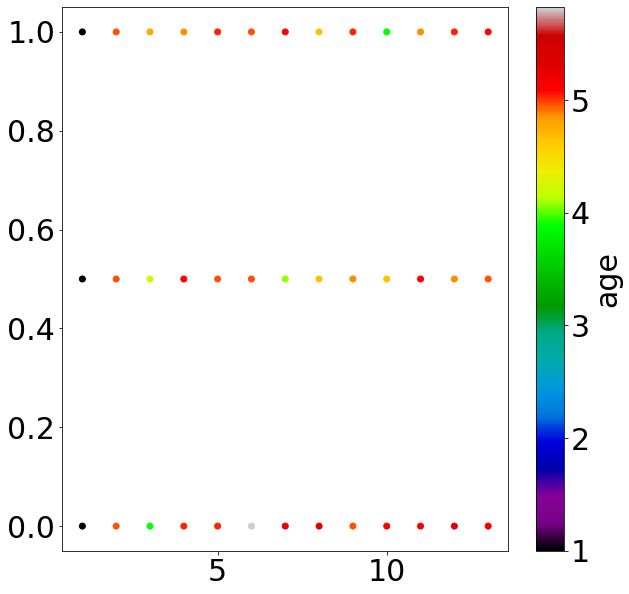

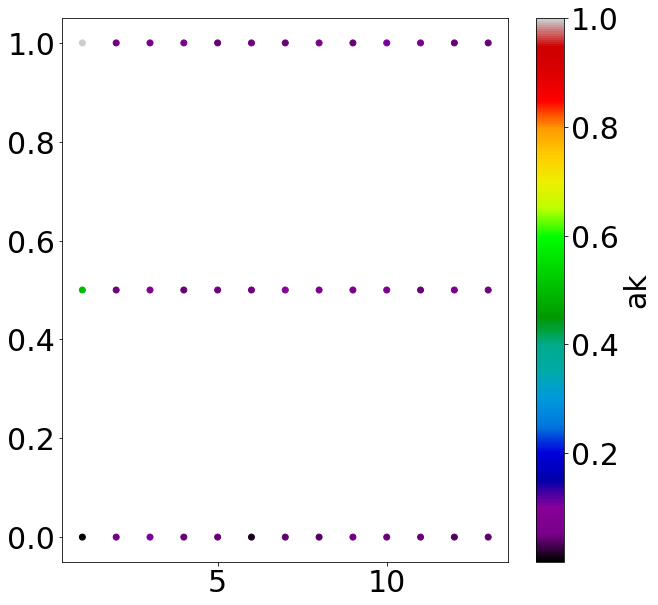

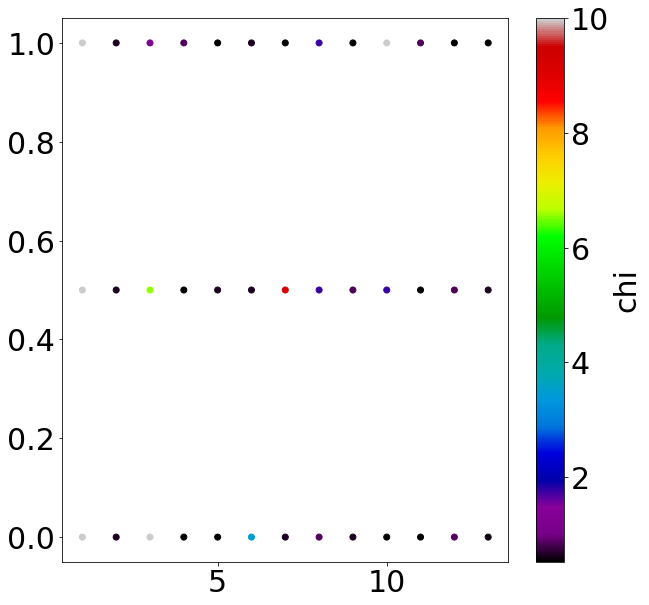

In [234]:
plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=age,cmap='nipy_spectral')
plt.colorbar(label='age')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=ak,cmap='nipy_spectral')
plt.colorbar(label='ak')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=chi,cmap='nipy_spectral',vmax=10)
plt.colorbar(label='chi')
plt.show()

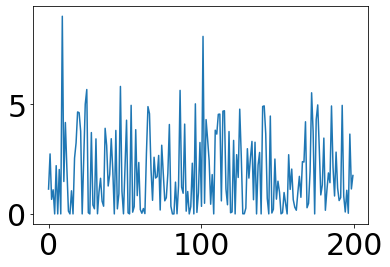

In [194]:
plt.plot(chis)

# Metallicity Check

In [167]:
def MetallicityMatch(teff,logg,isochrones):
    iso_ = Table(isochrones)
    lgteff = np.log10(teff)
    
    euclid = np.subtract(iso_['logTe'],lgteff)**2+np.subtract(iso_['logg'],logg)**2
    feh = iso_['MH'][euclid.argmin()]
    return feh

In [168]:
print('Isochrone Expectation',MetallicityMatch(gcs['TEFF'][1000],gcs['LOGG'][1000],massive))
print('Salaris',round(gcs['M_H'][1000]+np.log10(0.638*(10**gcs['ALPHA_M'][1000])+0.362),2))

Isochrone Expectation -1.05
Salaris -1.29


In [169]:
iso_exp = 999999.0*np.ones(len(gcs))
for i in tqdm_notebook(range(len(gcs))):
    iso_exp[i] = MetallicityMatch(gcs['TEFF'][i],gcs['LOGG'][i],massive)

sal_exp = np.round(gcs['M_H']+np.log10(0.638*(10**gcs['ALPHA_M'])+0.362),2)

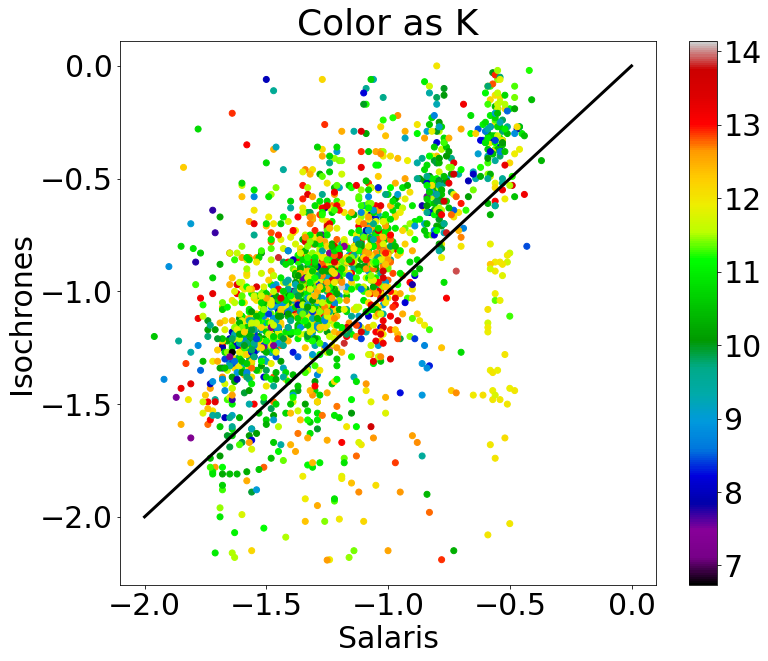

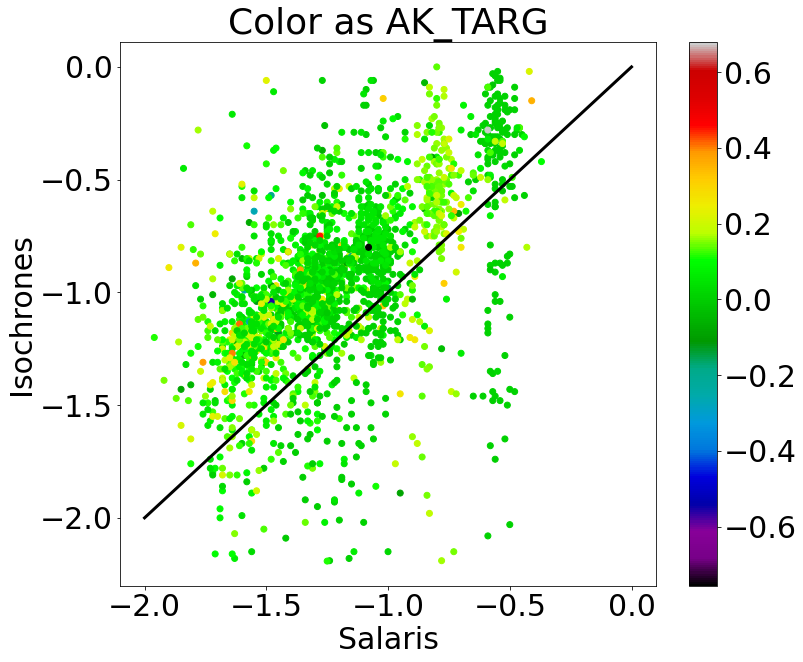

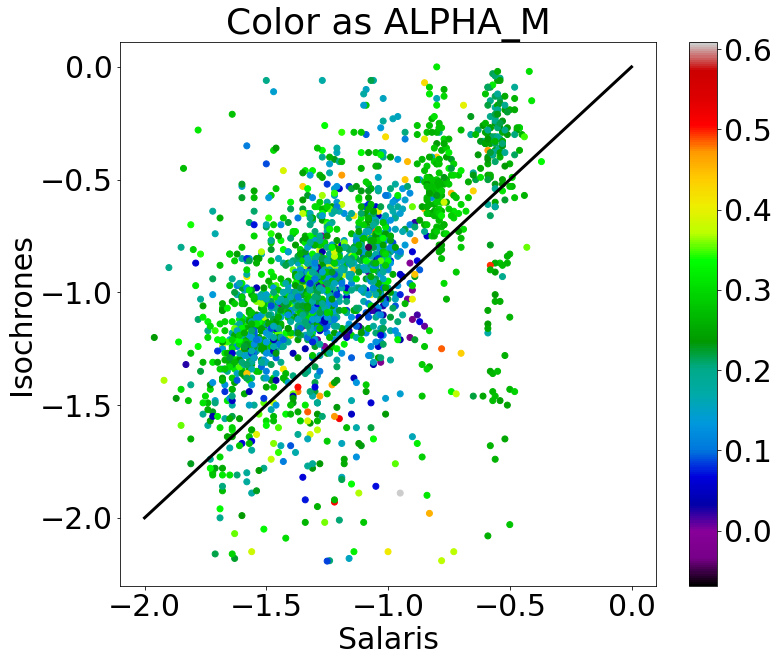

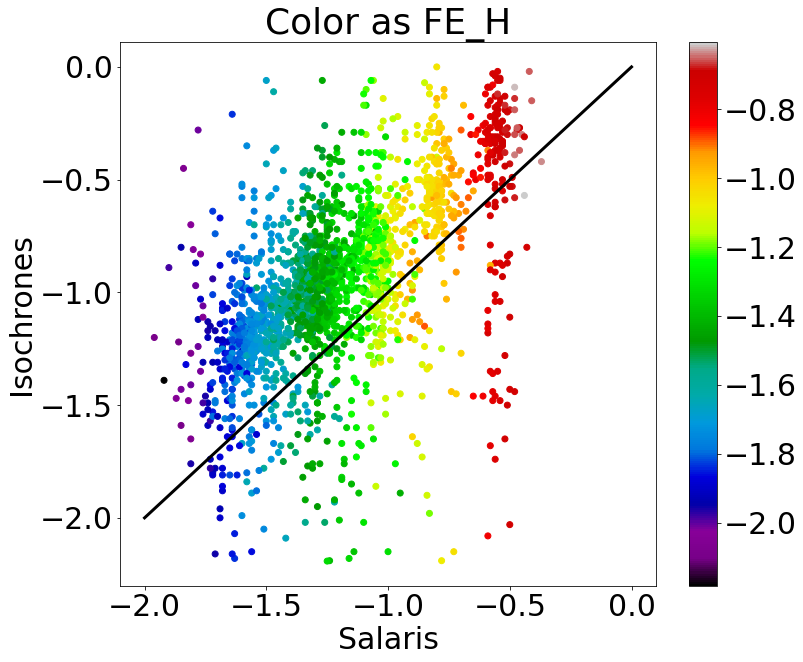

In [180]:
plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['K'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as K')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['AK_TARG'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as AK_TARG')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['ALPHA_M'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as ALPHA_M')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as FE_H')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()